<a href="https://colab.research.google.com/github/andrebarbosaalvesdossantos/poc-quarto-py/blob/main/soja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
# Instalando bibliotecas
!pip install pmdarima
!pip install scikit-learn
!pip install statsmodels

# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from pmdarima import arima
from statsmodels.tsa.stattools import adfuller # teste de Dickey-Fuller
from statsmodels.tsa.stattools import kpss # teste de Kwiatkowski-Phillips-Schmidt-Shin
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score # MSE, MAE, MAPE, R²

plt.rcParams['figure.figsize'] = 10,6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.4 MB/s eta 0:00:00


# Dados

In [2]:
# Importando arquivo xlsx
df = pd.read_excel('/content/soja (long).xlsx')

In [3]:
# Renomeando as colunas
df.columns = ['date', 'cm', 'cbot', 'ptax', 'cm_us', 'cbot_us', 'basis', 'basis_us', 'basis_pts', 'dia_semana', 'observações' ]
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301 entries, 0 to 1300
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1301 non-null   datetime64[ns]
 1   cm           1301 non-null   float64       
 2   cbot         1301 non-null   float64       
 3   ptax         1301 non-null   float64       
 4   cm_us        1301 non-null   float64       
 5   cbot_us      1301 non-null   float64       
 6   basis        1301 non-null   float64       
 7   basis_us     1301 non-null   float64       
 8   basis_pts    1301 non-null   float64       
 9   dia_semana   1301 non-null   object        
 10  observações  10 non-null     object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 111.9+ KB


In [4]:
# Criando uma nova tabela com os valores da coluna "basis_pts" e as datas como índice
df_basis = pd.DataFrame(
  data = {
    "date": df.date,
    "basis_pts": df.basis_pts,
    }
).set_index('date')
df_basis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1301 entries, 2000-01-05 to 2024-12-11
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   basis_pts  1301 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


In [5]:
# Tabela de estatística
df_basis.describe()

,basis_pts
count,1301.000000
mean,-59.806208
std,87.226705
min,-484.221267
25%,-107.310043
50%,-63.922524
75%,-11.738451
max,259.414006


# Visualização

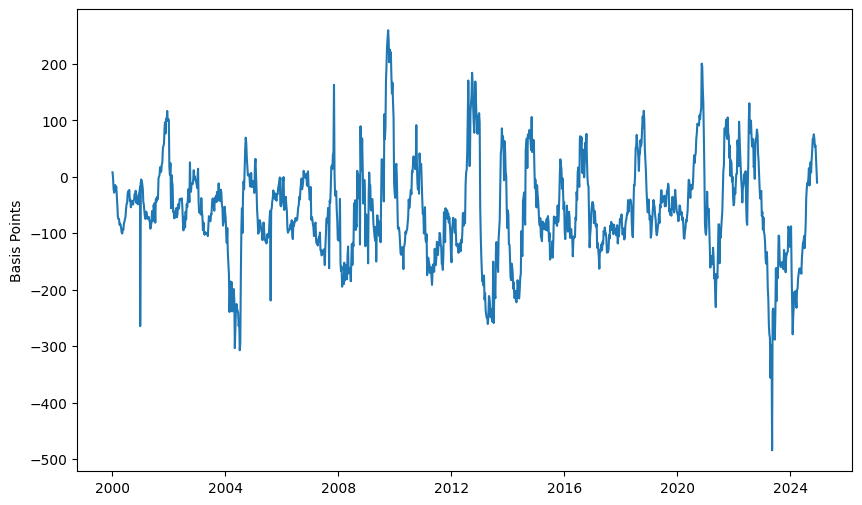

In [7]:
# Série temporal
plt.plot(df_basis.index, df_basis['basis_pts'])
plt.ylabel('Basis Points')
plt.show()

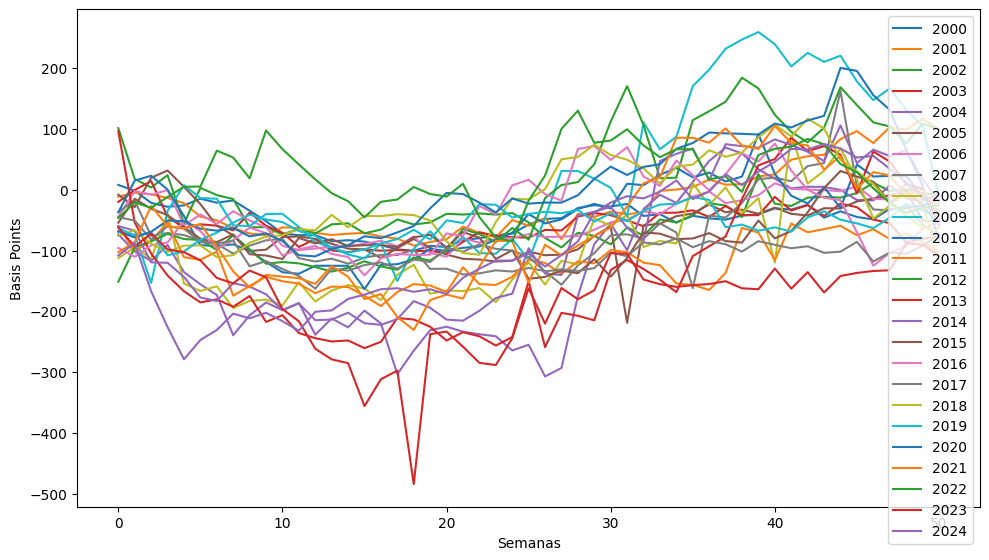

In [8]:
# Remodelando a tabela de dados original
basis_temp = []
for year in df['date'].dt.year.unique():
  temp = df[df['date'].dt.year == year][['date', 'basis_pts']]
  semana = 1
  basis_temp.append(list(temp[['basis_pts']].T.values[0]))

# Nova tabela (wide)
df_basis_temp = pd.DataFrame(basis_temp)
df_basis_temp['year'] = df['date'].dt.year.unique()
df_basis_temp = df_basis_temp.set_index('year')

# Gráfico com os anos sobrepostos
labels = []
for i, row in df_basis_temp[df_basis_temp.columns[:-1]].iterrows():
  plt.plot(df_basis_temp.columns[:-1], row)
  labels.append(i)
plt.legend(labels=labels)
plt.xlabel('Semanas')
plt.ylabel('Basis Points')
plt.tight_layout()
plt.show()

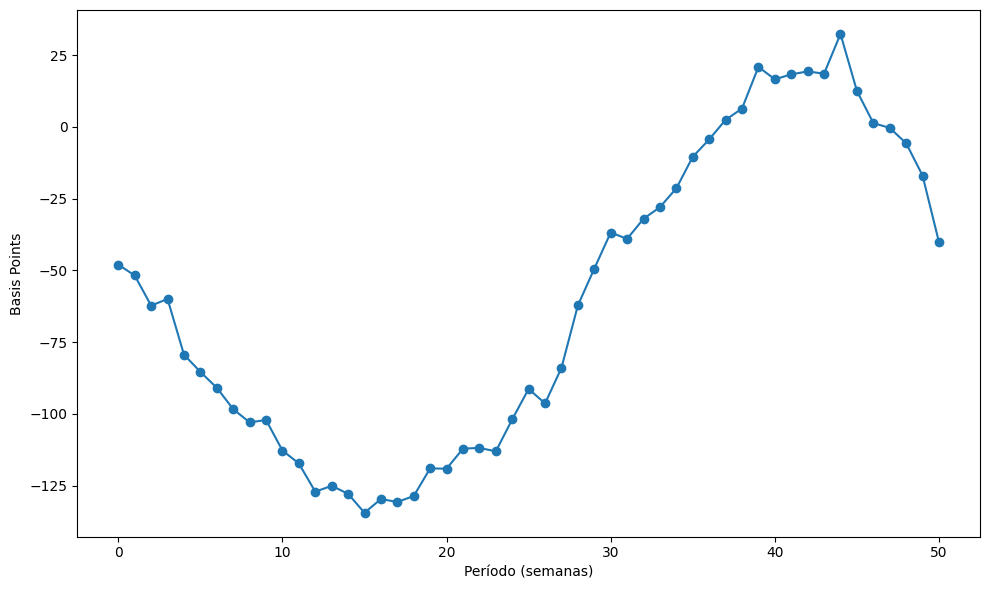

In [9]:
# Gráfico com a média entre os anos
basis_medio = list()
for i in df_basis_temp.columns[:-1]:
  basis_medio.append(df_basis_temp[i].mean())
plt.plot(basis_medio, marker = 'o')
plt.xlabel('Período (semanas)')
plt.ylabel('Basis Points')
plt.tight_layout()
plt.show()

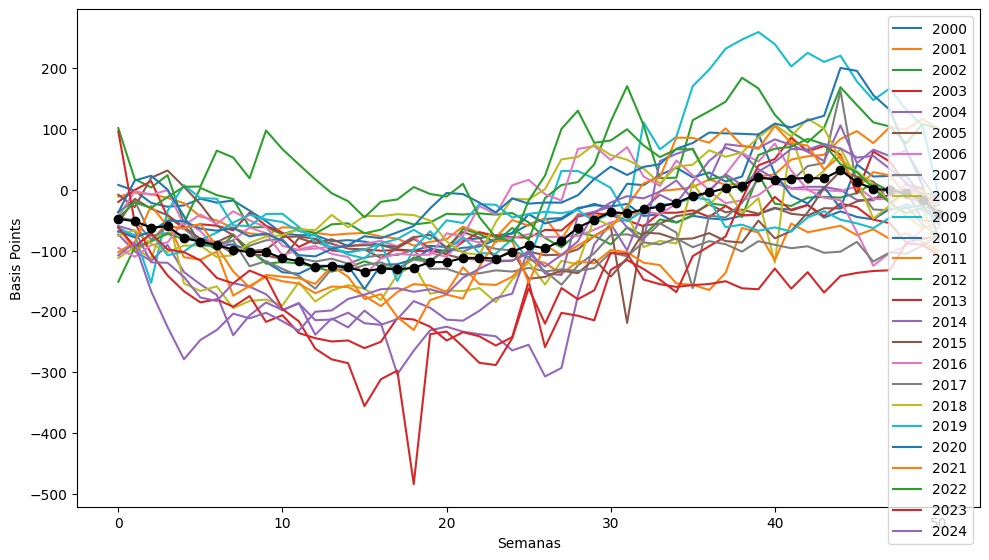

In [10]:
# Gráfico com os anos sobrepostos
labels = []
for i, row in df_basis_temp[df_basis_temp.columns[:-1]].iterrows():
  plt.plot(df_basis_temp.columns[:-1], row)
  labels.append(i)
plt.plot(basis_medio, marker = 'o', color = 'black')
plt.legend(labels=labels)
plt.xlabel('Semanas')
plt.ylabel('Basis Points')
plt.tight_layout()
plt.show()

In [11]:
# Estatísticas do primeiro semestre
primeiro_semestre = pd.DataFrame(
    data = {
        'basis_medio': basis_medio[0:26]
    }
)
primeiro_semestre.describe()

,basis_medio
count,26.000000
mean,-103.211694
std,25.475832
min,-134.485056
25%,-123.593200
50%,-112.005589
75%,-91.022006
max,-48.009043


In [12]:
# Estatísticas do segundo semestre
segundo_semestre = pd.DataFrame(
    data = {
        'basis_medio': basis_medio[26: 52]
    }
)
segundo_semestre.describe()

,basis_medio
count,25.000000
mean,-15.152977
std,33.628600
min,-96.380809
25%,-36.834272
50%,-5.726958
75%,12.534167
max,32.366900


# Raíz Unitária

In [6]:
# Dickey-Fuller Aumentado (ADF)
adf_basis = adfuller(df_basis['basis_pts'], autolag = 'AIC')
print(f'Estatística de teste: {adf_basis[0]:.13f}')
print(f'P-valor: {adf_basis[1]:.13f}')
print(f'Número de lags: {adf_basis[2]}')
print("Valores críticos:")
for key, value in adf_basis[4].items():
    print(key, ": ", value)
if adf_basis[1] < 0.05:
  print("\nNão existe raiz unitária: a série é estacionária.")
else:
  print("\nExiste raiz unitária: a série é não estacionária.")

Estatística de teste: -8.4421607569597
P-valor: 0.0000000000002
Número de lags: 12
Valores críticos:
1% :  -3.435437251933509
5% :  -2.863786592704128
10% :  -2.567966103183712

Não existe raiz unitária: a série é estacionária.


In [7]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
kpss_basis = kpss(df_basis['basis_pts'], nlags = 'auto')
print(f'Estatística de Teste: {kpss_basis[0]:.6f}')
print(f'P-valor: {kpss_basis[1]:.6f}')
print(f'Número de lags: {kpss_basis[2]}')
print(f'Valores Críticos:')
for key, value in kpss_basis[3].items():
    print(key, ": ", value)
if kpss_basis[1] > 0.05:
  print("\nNão existe raiz unitária: a série é estacionária.")
else:
  print("\nExiste raiz unitária: a série é não estacionária.")

Estatística de Teste: 0.044657
P-valor: 0.100000
Número de lags: 20
Valores Críticos:
10% :  0.347
5% :  0.463
2.5% :  0.574
1% :  0.739

Não existe raiz unitária: a série é estacionária.


<ipython-input-7-47387ab0742d>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_basis = kpss(df_basis['basis_pts'], nlags = 'auto')


# Escolha do Modelo

In [8]:
# SARIMA
modelo_sarima = auto_arima(
    df_basis,
    start_p = 0,
    start_q = 0,
    d = 0,
    max_p = 2,
    max_q = 0,
    max_d = 0,
    start_P = 0,
    start_Q = 0,
    D = 1,
    max_P = 2,
    max_D = 1,
    max_Q = 0,
    max_order = 5,
    m = 52,
    seasonal = True,
    trace = True,
    error_action = 'ignore',
    suppress_warnings = True,
    stepwise = True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=15212.580, Time=0.73 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=12559.279, Time=50.78 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=15210.937, Time=0.47 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=12934.863, Time=9.47 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=12424.793, Time=125.98 sec
 ARIMA(0,0,0)(2,1,0)[52] intercept   : AIC=14580.036, Time=135.99 sec
 ARIMA(2,0,0)(2,1,0)[52] intercept   : AIC=12397.151, Time=177.71 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=12530.257, Time=50.16 sec
 ARIMA(2,0,0)(2,1,0)[52]             : AIC=12395.341, Time=41.75 sec
 ARIMA(2,0,0)(1,1,0)[52]             : AIC=12528.393, Time=13.61 sec
 ARIMA(1,0,0)(2,1,0)[52]             : AIC=12423.071, Time=36.41 sec

Best model:  ARIMA(2,0,0)(2,1,0)[52]          
Total fit time: 643.142 seconds


In [9]:
# SARIMA
modelo_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1301
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 52)   Log Likelihood               -6192.671
Date:                            Fri, 13 Dec 2024   AIC                          12395.341
Time:                                    18:48:34   BIC                          12420.992
Sample:                                         0   HQIC                         12404.985
                                           - 1301                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7690      0.018     42.521      0.000       0.734       0.804
ar.L2          0.1534      0.019      7.901      0.000       0.115       0.191
ar.S.L52      -0.6797      0.022    -31.310      0.000      -0.722      -0.637
ar.S.L104     -0.3314      0.022    -14.792      0.000      -0.375      -0.287
sigma2      1158.6182     28.163     41.140      0.000    1103.419    1213.817
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               946.82
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.14
Prob(H) (two-sided):                  0.71   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Divisão da Amostra

In [10]:
# Treino
df_treino_2024 = df_basis.query('index < 2024')

In [11]:
# Teste
df_teste_2024 = df_basis.query('index >= 2024')

# Estimação e Previsão

###SARIMA

In [12]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2024 = modelo_sarima.fit(df_treino_2024) # estimação dos coeficientes da função
previsao_sarima_2024 = modelo_sarima_2024.predict(df_teste_2024.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [13]:
# Transformando a series "previsão" em um dataframe
df_previsao_sarima_2024 = pd.DataFrame(
    data = {
        "previsao": previsao_sarima_2024
    }
).set_index(df_teste_2024.index)

# Resultado

###SARIMA

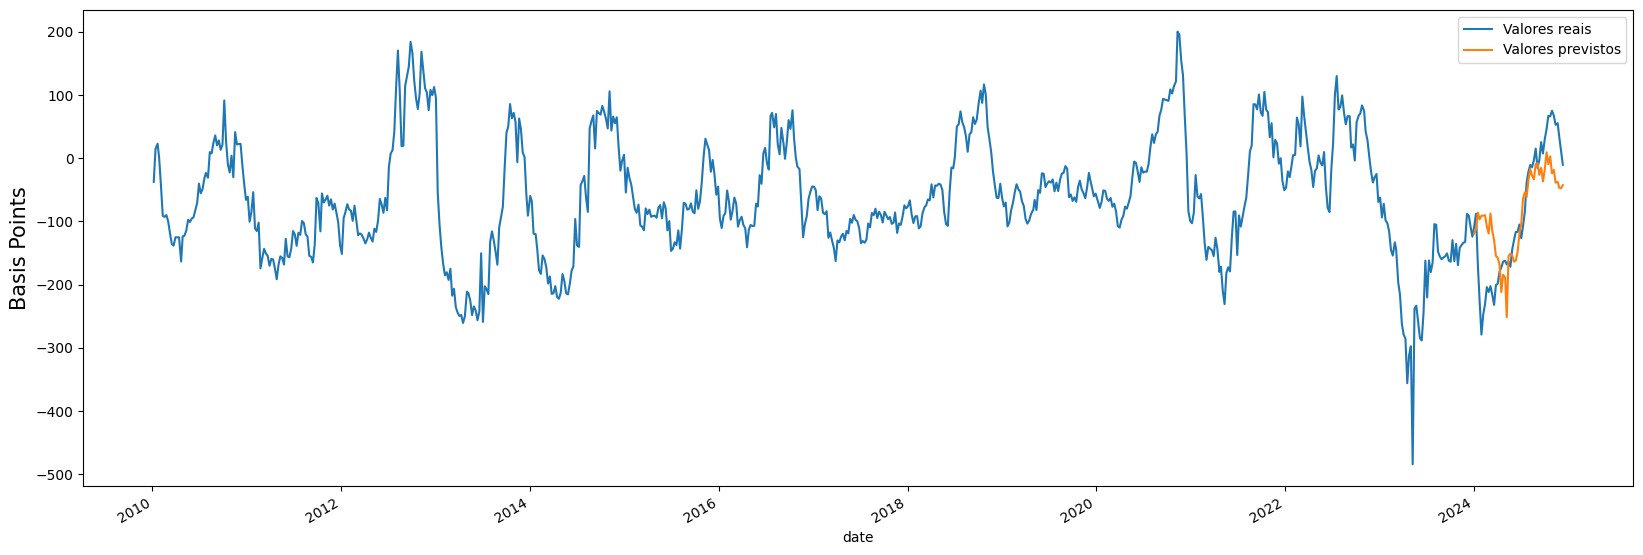

In [14]:
# Gráfico de comparação entre os valores de treino e teste e os previstos
pd.concat([df_basis.query('index > 2010'), df_previsao_sarima_2024], axis = 1).plot(figsize = (20, 7))
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

<Figure size 2000x500 with 0 Axes>

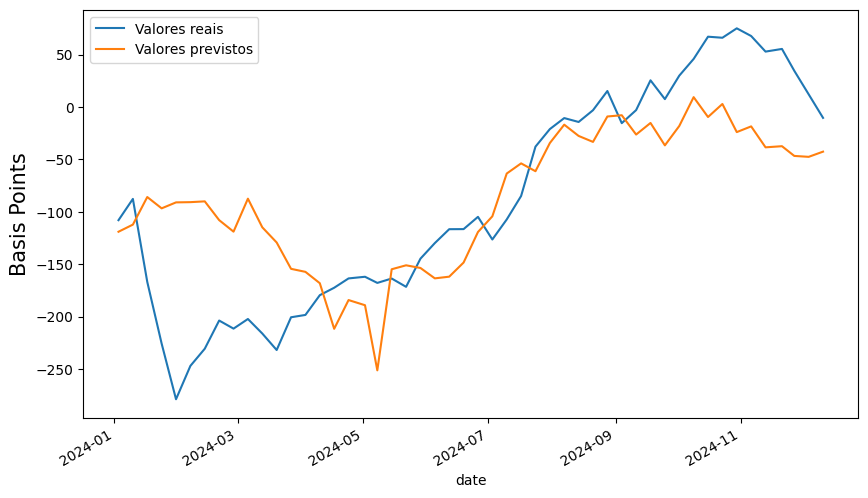

In [15]:
# Gráfico de comparação entre os valores de teste e os valores previstos
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2024, df_previsao_sarima_2024], axis = 1).plot()
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

#ERROS

###SARIMA

In [16]:
# Métodos de acurácia para 1 mês
print('1 mês')
mae_sarima_2024_1 = mean_absolute_error(df_teste_2024.query('index >= "2024-01-01" and index < "2024-02-01"'), df_previsao_sarima_2024.query('index >= "2024-01-01" and index < "2024-02-01"'))
print(f'MAE: {mae_sarima_2024_1}')

mape_sarima_2024_1 = mean_absolute_percentage_error(df_teste_2024.query('index >= "2024-01-01" and index < "2024-02-01"'), df_previsao_sarima_2024.query('index >= "2024-01-01" and index < "2024-02-01"'))
print(f'MAPE: {mape_sarima_2024_1}\n')

# Métodos de acurácia para 3 meses
print('3 meses')
mae_sarima_2024_3 = mean_absolute_error(df_teste_2024.query('index >= "2024-01-01" and index < "2024-04-01"'), df_previsao_sarima_2024.query('index >= "2024-01-01" and index < "2024-04-01"'))
print(f'MAE: {mae_sarima_2024_3}')

mape_sarima_2024_3 = mean_absolute_percentage_error(df_teste_2024.query('index >= "2024-01-01" and index < "2024-04-01"'), df_previsao_sarima_2024.query('index >= "2024-01-01" and index < "2024-04-01"'))
print(f'MAPE: {mape_sarima_2024_3}\n')

# Métodos de acurácia para 6 meses
print('6 meses')
mae_sarima_2024_6 = mean_absolute_error(df_teste_2024.query('index >= "2024-01-01" and index < "2024-07-01"'), df_previsao_sarima_2024.query('index >= "2024-01-01" and index < "2024-07-01"'))
print(f'MAE: {mae_sarima_2024_6}')

mape_sarima_2024_6 = mean_absolute_percentage_error(df_teste_2024.query('index >= "2024-01-01" and index < "2024-07-01"'), df_previsao_sarima_2024.query('index >= "2024-01-01" and index < "2024-07-01"'))
print(f'MAPE: {mape_sarima_2024_6}\n')

# Métodos de acurácia até o momento
print('Até o momento')
mae_sarima_2024_12 = mean_absolute_error(df_teste_2024, df_previsao_sarima_2024)
print(f'MAE: {mae_sarima_2024_12}')

mape_sarima_2024_12 = mean_absolute_percentage_error(df_teste_2024, df_previsao_sarima_2024)
print(f'MAPE: {mape_sarima_2024_12}')

1 mês
MAE: 86.73711175635373
MAPE: 0.4226168110042197

3 meses
MAE: 98.79496483115169
MAPE: 0.4594906172774816

6 meses
MAE: 64.27367231719849
MAPE: 0.3291626076828519

Até o momento
MAE: 55.245190624355835
MAPE: 1.2150970432665646


#RESÍDUOS

###SARIMA

# Reamostragem

## Pré Pandemia (2016-2019)

### 2000-2016

##### Dados

In [17]:
# Eliminando os anos indesejados da série
df_basis_2016 = df_basis.query('index < 2017')

##### Divisão da Amostra

In [18]:
# Treino
df_treino_2016 = df_basis.query('index < 2016')

In [19]:
# Teste
df_teste_2016 = df_basis.query('index >= 2016 and index < 2017')

##### Estimação e Previsão

In [20]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2016 = modelo_sarima.fit(df_treino_2016) # estimação dos coeficientes da função
previsao_2016 = modelo_sarima_2016.predict(df_teste_2016.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
# Transformando a serie de previsão em um dataframe
df_previsao_2016 = pd.DataFrame(
    previsao_2016,
    columns = ['previsao']
).set_index(df_teste_2016.index)

##### Resultado

<Figure size 2000x500 with 0 Axes>

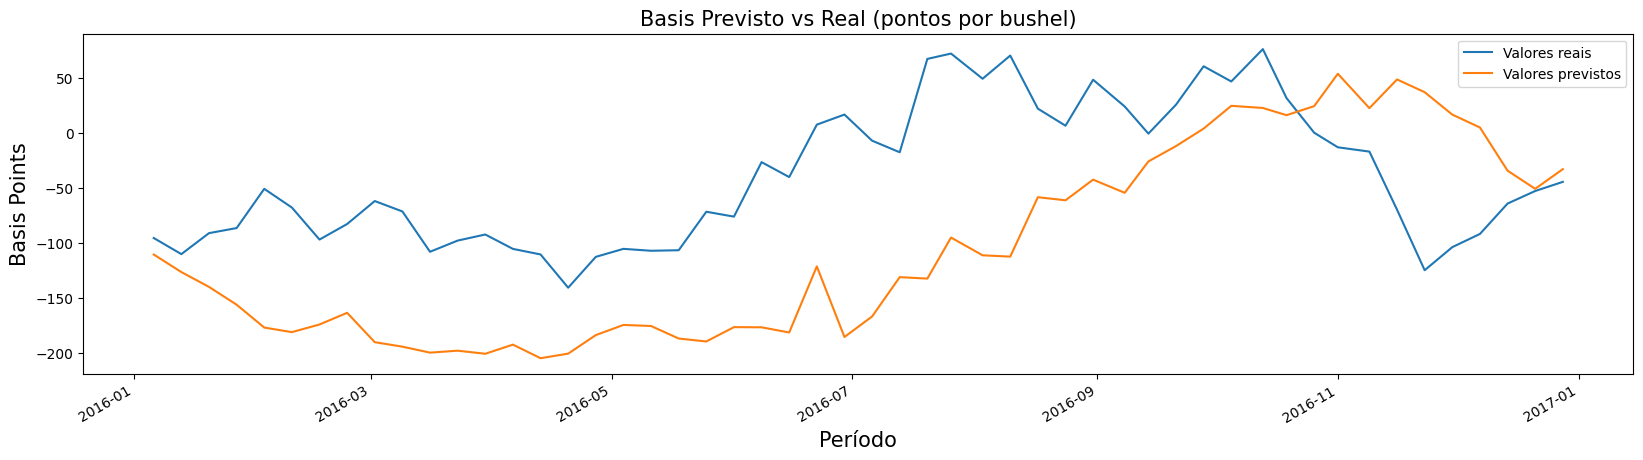

In [22]:
# Gráfico de comparação entre os valores de teste e os valores previstos
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2016, df_previsao_2016], axis = 1).plot(figsize = (20, 5))
plt.title('Basis Previsto vs Real (pontos por bushel)', size = 15)
plt.xlabel('Período', size = 15)
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

In [23]:
# Métodos de acurácia para 1 mês
print('1 mês:')
mae_2016_1 = mean_absolute_error(df_teste_2016.query('index >= "2016-01-01" and index < "2016-02-01"'), df_previsao_2016.query('index >= "2016-01-01" and index < "2016-02-01"'))
print(f'MAE: {mae_2016_1}')

mape_2016_1 = mean_absolute_percentage_error(df_teste_2016.query('index >= "2016-01-01" and index < "2016-02-01"'), df_previsao_2016.query('index >= "2016-01-01" and index < "2016-02-01"'))
print(f'MAPE: {mape_2016_1}\n')

# Métodos de acurácia para 3 meses
print('3 meses:')
mae_2016_3 = mean_absolute_error(df_teste_2016.query('index >= "2016-01-01" and index < "2016-04-01"'), df_previsao_2016.query('index >= "2016-01-01" and index < "2016-04-01"'))
print(f'MAE: {mae_2016_3}')

mape_2016_3 = mean_absolute_percentage_error(df_teste_2016.query('index >= "2016-01-01" and index < "2016-04-01"'), df_previsao_2016.query('index >= "2016-01-01" and index < "2016-04-01"'))
print(f'MAPE: {mape_2016_3}\n')

# Métodos de acurácia para 6 meses
print(f'6 meses:')
mae_2016_6 = mean_absolute_error(df_teste_2016.query('index >= "2016-01-01" and index < "2016-07-01"'), df_previsao_2016.query('index >= "2016-01-01" and index < "2016-07-01"'))
print(f'MAE: {mae_2016_6}')

mape_2016_6 = mean_absolute_percentage_error(df_teste_2016.query('index >= "2016-01-01" and index < "2016-07-01"'), df_previsao_2016.query('index >= "2016-01-01" and index < "2016-07-01"'))
print(f'MAPE: {mape_2016_6}\n')

# Métodos de acurácia para 12 meses
print(f'12 meses:')
mae_2016_12 = mean_absolute_error(df_teste_2016, df_previsao_2016)
print(f'MAE: {mae_2016_12}')

mape_2016_12 = mean_absolute_percentage_error(df_teste_2016, df_previsao_2016)
print(f'MAPE: {mape_2016_12}')

1 mês:
MAE: 37.43160496554587
MAPE: 0.410691264072994

3 meses:
MAE: 84.4402388279735
MAPE: 1.1047924692410873

6 meses:
MAE: 94.91734140714978
MAPE: 2.3503889760935732

12 meses:
MAE: 89.41573397963764
MAPE: 108.93510300659901


### 2000-2017

##### Dados

In [24]:
# Eliminando os anos indesejados da série
df_basis_2017 = df_basis.query('index < 2018')

##### Divisão da Amostra

In [25]:
# Treino
df_treino_2017 = df_basis.query('index < 2017')

In [26]:
# Teste
df_teste_2017 = df_basis.query('index >= 2017 and index < 2018')

##### Estimação e Previsão

In [27]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2017 = modelo_sarima.fit(df_treino_2017) # estimação dos coeficientes da função
previsao_2017 = modelo_sarima_2017.predict(df_teste_2017.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [28]:
# Transformando a serie de previsão em um dataframe
df_previsao_2017 = pd.DataFrame(
    previsao_2017,
    columns = ['previsao']
).set_index(df_teste_2017.index)

##### Resultado

<Figure size 2000x500 with 0 Axes>

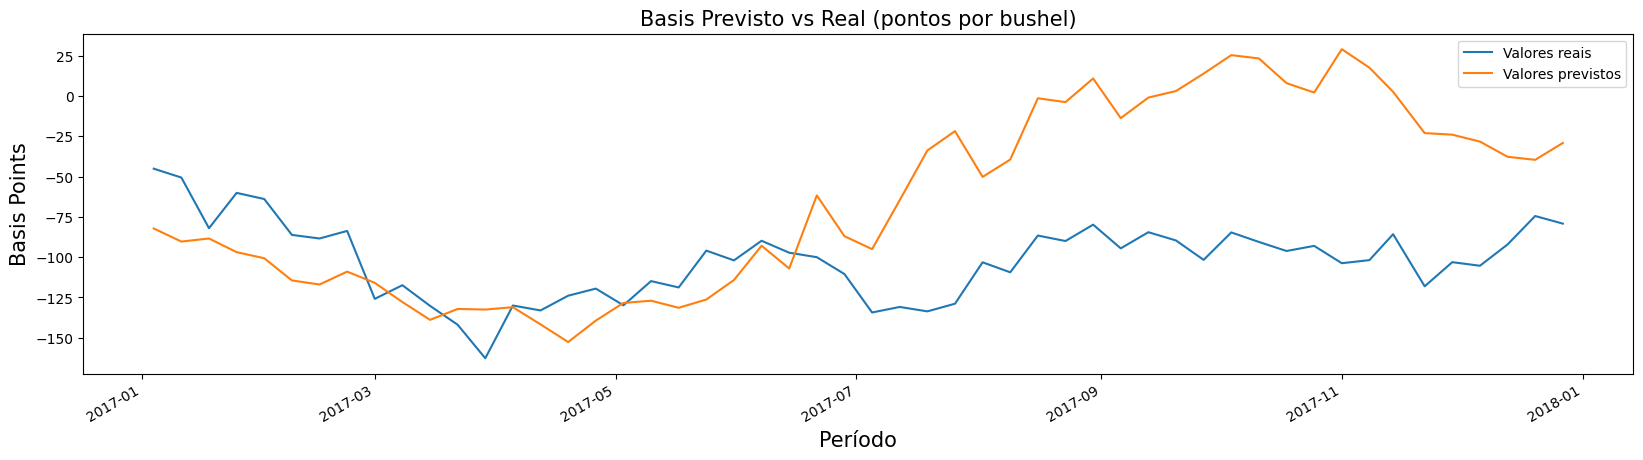

In [29]:
# Gráfico de comparação entre os valores de teste e os valores previstos
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2017, df_previsao_2017], axis = 1).plot(figsize = (20, 5))
plt.title('Basis Previsto vs Real (pontos por bushel)', size = 15)
plt.xlabel('Período', size = 15)
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

In [30]:
# Métodos de acurácia para 1 mês
print('1 mês:')
mae_2017_1 = mean_absolute_error(df_teste_2017.query('index >= "2017-01-01" and index < "2017-02-01"'), df_previsao_2017.query('index >= "2017-01-01" and index < "2017-02-01"'))
print(f'MAE: {mae_2017_1}')

mape_2017_1 = mean_absolute_percentage_error(df_teste_2017.query('index >= "2017-01-01" and index < "2017-02-01"'), df_previsao_2017.query('index >= "2017-01-01" and index < "2017-02-01"'))
print(f'MAPE: {mape_2017_1}.\n')

# Métodos de acurácia para 3 meses
print('3 meses;')
mae_2017_3 = mean_absolute_error(df_teste_2017.query('index >= "2017-01-01" and index < "2017-04-01"'), df_previsao_2017.query('index >= "2017-01-01" and index < "2017-04-01"'))
print(f'MAE: {mae_2017_3}')

mape_2017_3 = mean_absolute_percentage_error(df_teste_2017.query('index >= "2017-01-01" and index < "2017-04-01"'), df_previsao_2017.query('index >= "2017-01-01" and index < "2017-04-01"'))
print(f'MAPE: {mape_2017_3}.\n')

# Métodos de acurácia para 6 meses
print(f'6 meses:')
mae_2017_6 = mean_absolute_error(df_teste_2017.query('index >= "2017-01-01" and index < "2017-07-01"'), df_previsao_2017.query('index >= "2017-01-01" and index < "2017-07-01"'))
print(f'MAE: {mae_2017_6}')

mape_2017_6 = mean_absolute_percentage_error(df_teste_2017.query('index >= "2017-01-01" and index < "2017-07-01"'), df_previsao_2017.query('index >= "2017-01-01" and index < "2017-07-01"'))
print(f'MAPE: {mape_2017_6}.\n')

# Métodos de acurácia para 12 meses
print(f'12 meses:')
mae_2017_12 = mean_absolute_error(df_teste_2017, df_previsao_2017)
print(f'MAE: {mae_2017_12}')

mape_2017_12 = mean_absolute_percentage_error(df_teste_2017, df_previsao_2017)
print(f'MAPE: {mape_2017_12}.')

1 mês:
MAE: 29.99293183056347
MAPE: 0.5743333343348096.

3 meses;
MAE: 23.681369597536822
MAPE: 0.3318393808429203.

6 meses:
MAE: 19.599473559176545
MAPE: 0.23749788794315713.

12 meses:
MAE: 52.570865166614404
MAPE: 0.556468508993875.


### 2000-2018

##### Dados

In [31]:
# Eliminando os anos indesejados da série
df_basis_2018 = df_basis.query('index < 2019')

##### Divisão da Amostra

In [32]:
# Treino
df_treino_2018 = df_basis.query('index < 2018')

In [33]:
# Teste
df_teste_2018 = df_basis.query('index >= 2018 and index < 2019')

##### Estimação e Previão

In [34]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2018 = modelo_sarima.fit(df_treino_2018) # estimação dos coeficientes da função
previsao_2018 = modelo_sarima_2018.predict(df_teste_2018.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [35]:
# Transformando a serie de previsão em um dataframe
df_previsao_2018 = pd.DataFrame(
    previsao_2018,
    columns = ['previsao']
).set_index(df_teste_2018.index)

##### Resultado

<Figure size 2000x500 with 0 Axes>

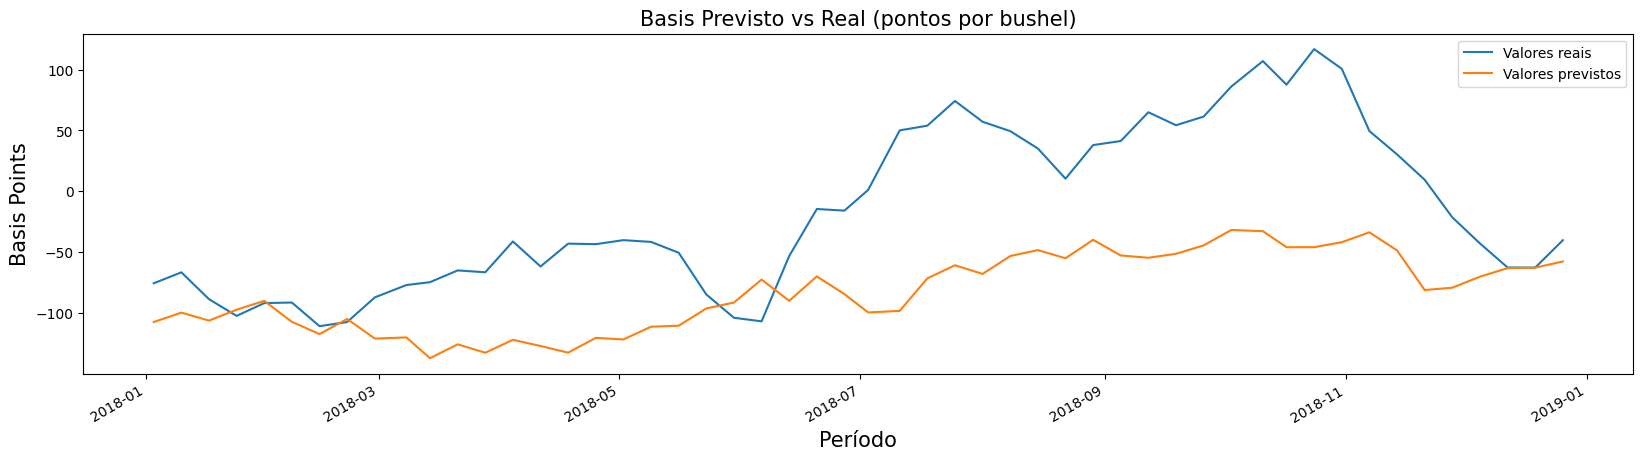

In [36]:
# Gráfico de comparação entre os valores de teste e os valores previstos
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2018, df_previsao_2018], axis = 1).plot(figsize = (20, 5))
plt.title('Basis Previsto vs Real (pontos por bushel)', size = 15)
plt.xlabel('Período', size = 15)
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

In [37]:
# Métodos de acurácia para 1 mês
print('1 mês:')
mae_2018_1 = mean_absolute_error(df_teste_2018.query('index >= "2018-01-01" and index < "2018-02-01"'), df_previsao_2018.query('index >= "2018-01-01" and index < "2018-02-01"'))
print(f'MAE: {mae_2018_1}')

mape_2018_1 = mean_absolute_percentage_error(df_teste_2018.query('index >= "2018-01-01" and index < "2018-02-01"'), df_previsao_2018.query('index >= "2018-01-01" and index < "2018-02-01"'))
print(f'MAPE: {mape_2018_1}.\n')

# Métodos de acurácia para 3 meses
print('3 meses:')
mae_2018_3 = mean_absolute_error(df_teste_2018.query('index >= "2018-01-01" and index < "2018-04-01"'), df_previsao_2018.query('index >= "2018-01-01" and index < "2018-04-01"'))
print(f'MAE: {mae_2018_3}')

mape_2018_3 = mean_absolute_percentage_error(df_teste_2018.query('index >= "2018-01-01" and index < "2018-04-01"'), df_previsao_2018.query('index >= "2018-01-01" and index < "2018-04-01"'))
print(f'MAPE: {mape_2018_3}.\n')

# Métodos de acurácia para 6 meses
print(f'6 meses:')
mae_2018_6 = mean_absolute_error(df_teste_2018.query('index >= "2018-01-01" and index < "2018-07-01"'), df_previsao_2018.query('index >= "2018-01-01" and index < "2018-07-01"'))
print(f'MAE: {mae_2018_6}')

mape_2018_6 = mean_absolute_percentage_error(df_teste_2018.query('index >= "2018-01-01" and index < "2018-07-01"'), df_previsao_2018.query('index >= "2018-01-01" and index < "2018-07-01"'))
print(f'MAPE: {mape_2018_6}.\n')

# Métodos de acurácia para 12 meses
print(f'12 meses:')
mae_2018_12 = mean_absolute_error(df_teste_2018, df_previsao_2018)
print(f'MAE: {mae_2018_12}')

mape_2018_12 = mean_absolute_percentage_error(df_teste_2018, df_previsao_2018)
print(f'MAPE: {mape_2018_12}.')

1 mês:
MAE: 17.887405479370784
MAPE: 0.23699090224739439.

3 meses:
MAE: 29.277415264008532
MAPE: 0.39606843752998494.

6 meses:
MAE: 43.23036926421768
MAPE: 1.0104357435116336.

12 meses:
MAE: 68.57943176012546
MAPE: 3.334611736068836.


### 2000-2019

##### Dados

In [38]:
# Eliminando os anos indesejados da série
df_basis_2019 = df_basis.query('index < 2020')

##### Divisão da Amostra

In [39]:
# Treino
df_treino_2019 = df_basis.query('index < 2019')

In [40]:
# Teste
df_teste_2019 = df_basis.query('index >= 2019 and index < 2020')

##### Estimação e Previsão

In [41]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2019 = modelo_sarima.fit(df_treino_2019) # estimação dos coeficientes da função
previsao_2019 = modelo_sarima_2019.predict(df_teste_2019.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
# Transformando a serie de previsão em um dataframe
df_previsao_2019 = pd.DataFrame(
    previsao_2019,
    columns = ['previsao']
).set_index(df_teste_2019.index)

##### Resultado

<Figure size 2000x500 with 0 Axes>

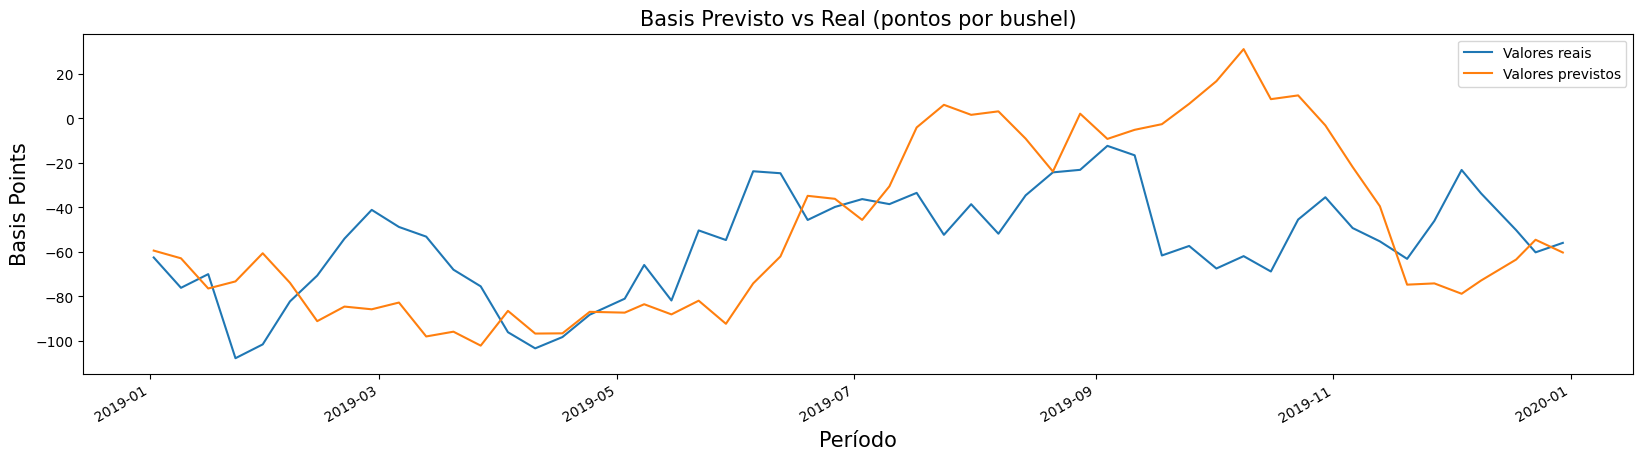

In [43]:
# Gráfico de comparação entre os valores de teste e os valores previstos
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2019, df_previsao_2019], axis = 1).plot(figsize = (20, 5))
plt.title('Basis Previsto vs Real (pontos por bushel)', size = 15)
plt.xlabel('Período', size = 15)
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

In [44]:
# Métodos de acurácia para 1 mês
print('1 mês:')
mae_2019_1 = mean_absolute_error(df_teste_2019.query('index >= "2019-01-01" and index < "2019-02-01"'), df_previsao_2019.query('index >= "2019-01-01" and index < "2019-02-01"'))
print(f'MAE: {mae_2019_1}')

mape_2019_1 = mean_absolute_percentage_error(df_teste_2019.query('index >= "2019-01-01" and index < "2019-02-01"'), df_previsao_2019.query('index >= "2019-01-01" and index < "2019-02-01"'))
print(f'MAPE: {mape_2019_1}.\n')

# Métodos de acurácia para 3 meses
print('3 meses:')
mae_2019_3 = mean_absolute_error(df_teste_2019.query('index >= "2019-01-01" and index < "2019-04-01"'), df_previsao_2019.query('index >= "2019-01-01" and index < "2019-04-01"'))
print(f'MAE: {mae_2019_3}')

mape_2019_3 = mean_absolute_percentage_error(df_teste_2019.query('index >= "2019-01-01" and index < "2019-04-01"'), df_previsao_2019.query('index >= "2019-01-01" and index < "2019-04-01"'))
print(f'MAPE: {mape_2019_3}.\n')

# Métodos de acurácia para 6 meses
print(f'6 meses:')
mae_2019_6 = mean_absolute_error(df_teste_2019.query('index >= "2019-01-01" and index < "2019-07-01"'), df_previsao_2019.query('index >= "2019-01-01" and index < "2019-07-01"'))
print(f'MAE: {mae_2019_6}')

mape_2019_6 = mean_absolute_percentage_error(df_teste_2019.query('index >= "2019-01-01" and index < "2019-07-01"'), df_previsao_2019.query('index >= "2019-01-01" and index < "2019-07-01"'))
print(f'MAPE: {mape_2019_6}.\n')

# Métodos de acurácia para 12 meses
print(f'12 meses:')
mae_2019_12 = mean_absolute_error(df_teste_2019, df_previsao_2019)
print(f'MAE: {mae_2019_12}')

mape_2019_12 = mean_absolute_percentage_error(df_teste_2019, df_previsao_2019)
print(f'MAPE: {mape_2019_12}.')

1 mês:
MAE: 19.66205808929207
MAPE: 0.20784240942246793.

3 meses:
MAE: 25.830748509699806
MAPE: 0.41430982239967357.

6 meses:
MAE: 21.414746632232397
MAPE: 0.43413947496151317.

12 meses:
MAE: 28.109410693170542
MAPE: 0.610602838808709.


## Pós Pandemia (2020-2023)

### 2000-2020

##### Dados

In [45]:
# Eliminando os anos indesejados da série
df_basis_2020 = df_basis.query('index < 2021')

##### Divisão da Amostra

In [46]:
# Treino
df_treino_2020 = df_basis.query('index < 2020')

In [47]:
# Teste
df_teste_2020 = df_basis.query('index >= 2020 and index < 2021')

##### Estimação e Previsão

In [48]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2020 = modelo_sarima.fit(df_treino_2020) # estimação dos coeficientes da função
previsao_2020 = modelo_sarima_2020.predict(df_teste_2020.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [49]:
# Transformando a serie de previsão em um dataframe
df_previsao_2020 = pd.DataFrame(
    previsao_2020,
    columns = ['previsao']
).set_index(df_teste_2020.index)

##### Resultado

<Figure size 2000x500 with 0 Axes>

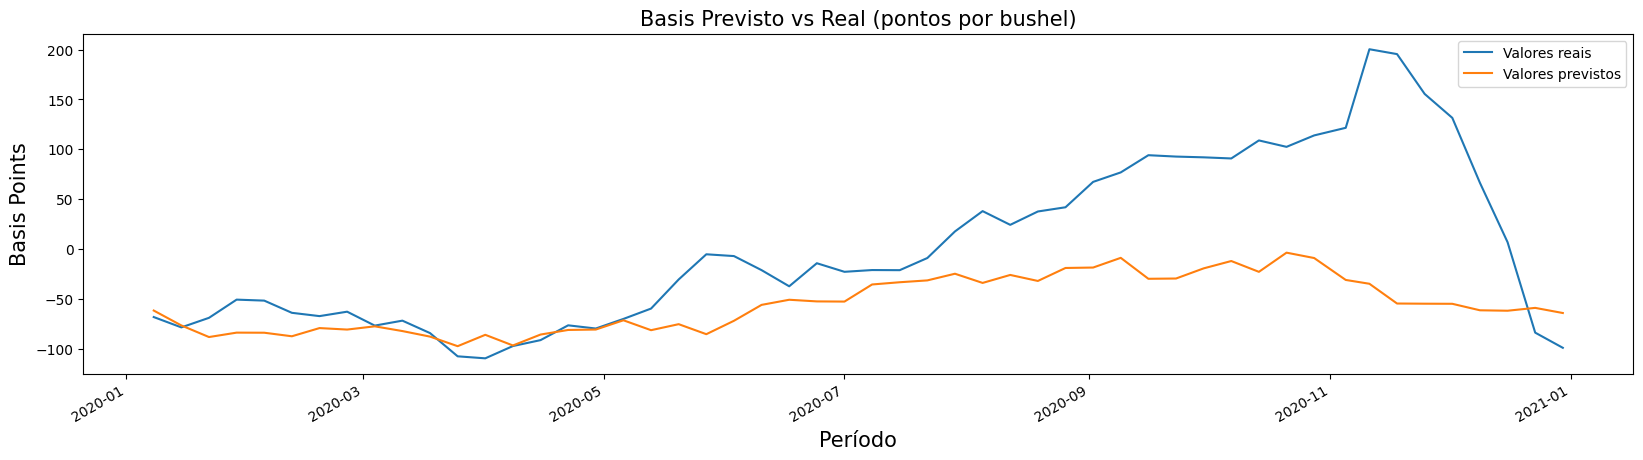

In [50]:
# Gráfico de comparação entre os valores de teste e os valores previstos
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2020, df_previsao_2020], axis = 1).plot(figsize = (20, 5))
plt.title('Basis Previsto vs Real (pontos por bushel)', size = 15)
plt.xlabel('Período', size = 15)
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

In [51]:
# Métodos de acurácia para 1 mês
print('1 mês:')
mae_2020_1 = mean_absolute_error(df_teste_2020.query('index >= "2020-01-01" and index < "2020-02-01"'), df_previsao_2020.query('index >= "2020-01-01" and index < "2020-02-01"'))
print(f'MAE: {mae_2020_1}')

mape_2020_1 = mean_absolute_percentage_error(df_teste_2020.query('index >= "2020-01-01" and index < "2020-02-01"'), df_previsao_2020.query('index >= "2020-01-01" and index < "2020-02-01"'))
print(f'MAPE: {mape_2020_1}.\n')

# Métodos de acurácia para 3 meses
print('3 meses:')
mae_2020_3 = mean_absolute_error(df_teste_2020.query('index >= "2020-01-01" and index < "2020-04-01"'), df_previsao_2020.query('index >= "2020-01-01" and index < "2020-04-01"'))
print(f'MAE: {mae_2020_3}')

mape_2020_3 = mean_absolute_percentage_error(df_teste_2020.query('index >= "2020-01-01" and index < "2020-04-01"'), df_previsao_2020.query('index >= "2020-01-01" and index < "2020-04-01"'))
print(f'MAPE: {mape_2020_3}.\n')

# Métodos de acurácia para 6 meses
print(f'6 meses:')
mae_2020_6 = mean_absolute_error(df_teste_2020.query('index >= "2020-01-01" and index < "2020-07-01"'), df_previsao_2020.query('index >= "2020-01-01" and index < "2020-07-01"'))
print(f'MAE: {mae_2020_6}')

mape_2020_6 = mean_absolute_percentage_error(df_teste_2020.query('index >= "2020-01-01" and index < "2020-07-01"'), df_previsao_2020.query('index >= "2020-01-01" and index < "2020-07-01"'))
print(f'MAPE: {mape_2020_6}.\n')

# Métodos de acurácia para 12 meses
print(f'12 meses:')
mae_2020_12 = mean_absolute_error(df_teste_2020, df_previsao_2020)
print(f'MAE: {mae_2020_12}')

mape_2020_12 = mean_absolute_percentage_error(df_teste_2020, df_previsao_2020)
print(f'MAPE: {mape_2020_12}.')

1 mês:
MAE: 15.211779005410257
MAPE: 0.2630157694801617.

3 meses:
MAE: 14.281498380105873
MAPE: 0.23309240842689619.

6 meses:
MAE: 20.2548386291476
MAPE: 1.3637820307289088.

12 meses:
MAE: 60.85980139803232
MAPE: 1.5112574289436744.


### 2000-2021

##### Dados

In [52]:
# Eliminando os anos indesejados da série
df_basis_2021 = df_basis.query('index < 2022')

##### Divisão da Amostra

In [53]:
# Treino
df_treino_2021 = df_basis.query('index < 2021')

In [54]:
# Teste
df_teste_2021 = df_basis.query('index >= 2021 and index < 2022')

##### Estimação e Previsão

In [55]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2021 = modelo_sarima.fit(df_treino_2021) # estimação dos coeficientes da função
previsao_2021 = modelo_sarima_2021.predict(df_teste_2021.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [56]:
# Transformando a series "previsão" em um dataframe
df_previsao_2021 = pd.DataFrame(
    data = {
        "previsao": previsao_2021
    }
).set_index(df_teste_2021.index)

##### Resultado

<Figure size 2000x500 with 0 Axes>

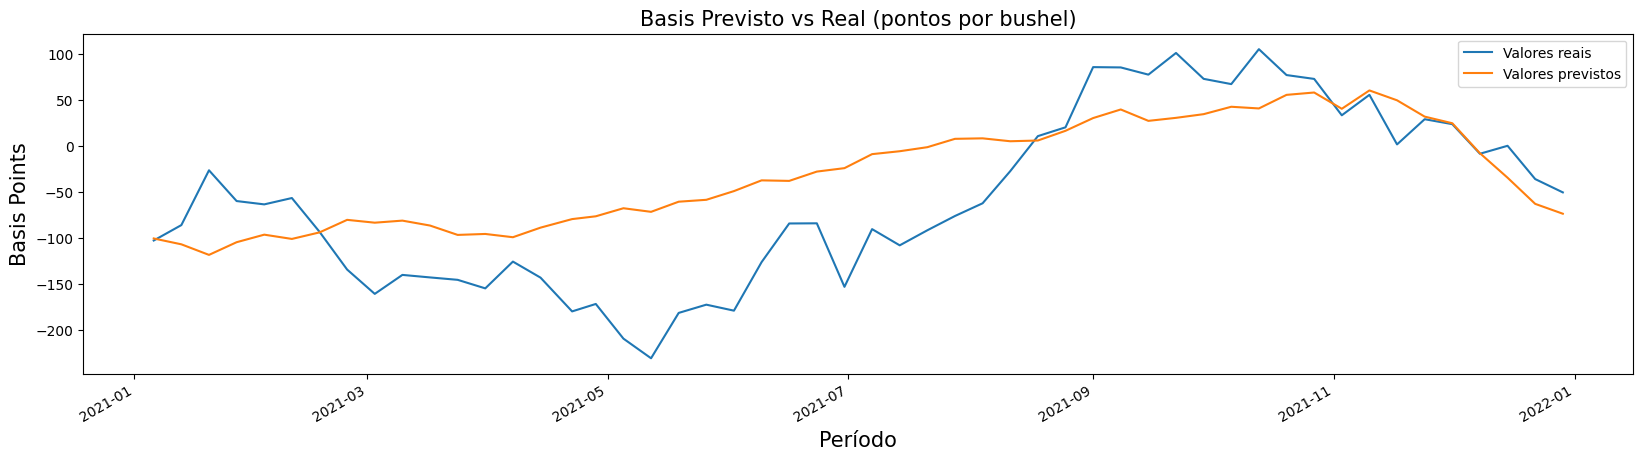

In [57]:
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2021, df_previsao_2021], axis = 1).plot(figsize = (20, 5))
plt.title('Basis Previsto vs Real (pontos por bushel)', size = 15)
plt.xlabel('Período', size = 15)
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

In [58]:
# Métodos de acurácia para 1 mês
print('1 mês:')
mae_2021_1 = mean_absolute_error(df_teste_2021.query('index >= "2021-01-01" and index < "2021-02-01"'), df_previsao_2021.query('index >= "2021-01-01" and index < "2021-02-01"'))
print(f'MAE: {mae_2021_1}')

mape_2021_1 = mean_absolute_percentage_error(df_teste_2021.query('index >= "2021-01-01" and index < "2021-02-01"'), df_previsao_2021.query('index >= "2021-01-01" and index < "2021-02-01"'))
print(f'MAPE: {mape_2021_1}.\n')

# Métodos de acurácia para 3 meses
print('3 meses:')
mae_2021_3 = mean_absolute_error(df_teste_2021.query('index >= "2021-01-01" and index < "2021-04-01"'), df_previsao_2021.query('index >= "2021-01-01" and index < "2021-04-01"'))
print(f'MAE: {mae_2021_3}')

mape_2021_3 = mean_absolute_percentage_error(df_teste_2021.query('index >= "2021-01-01" and index < "2021-04-01"'), df_previsao_2021.query('index >= "2021-01-01" and index < "2021-04-01"'))
print(f'MAPE: {mape_2021_3}.\n')

# Métodos de acurácia para 6 meses
print(f'6 meses:')
mae_2021_6 = mean_absolute_error(df_teste_2021.query('index >= "2021-01-01" and index < "2021-07-01"'), df_previsao_2021.query('index >= "2021-01-01" and index < "2021-07-01"'))
print(f'MAE: {mae_2021_6}')

mape_2021_6 = mean_absolute_percentage_error(df_teste_2021.query('index >= "2021-01-01" and index < "2021-07-01"'), df_previsao_2021.query('index >= "2021-01-01" and index < "2021-07-01"'))
print(f'MAPE: {mape_2021_6}.\n')

# Métodos de acurácia para 12 meses
print(f'12 meses:')
mae_2021_12 = mean_absolute_error(df_teste_2021, df_previsao_2021)
print(f'MAE: {mae_2021_12}')

mape_2021_12 = mean_absolute_percentage_error(df_teste_2021, df_previsao_2021)
print(f'MAPE: {mape_2021_12}.')

1 mês:
MAE: 39.935495158446514
MAPE: 1.1194254563038188.

3 meses:
MAE: 45.568284334638705
MAPE: 0.6309979416066762.

6 meses:
MAE: 71.32439592890213
MAPE: 0.6187008961159853.

12 meses:
MAE: 54.966128904741055
MAPE: 6.8457108549764705.


### 2000-2022

##### Dados

In [59]:
# Eliminando os anos indesejados da série
df_basis_2022 = df_basis.query('index < 2023')

##### Divisão da Amostra

In [60]:
# Treino
df_treino_2022 = df_basis.query('index < 2022')

In [61]:
# Teste
df_teste_2022 = df_basis.query('index >= 2022 and index < 2023')

##### Estimação e Previsão

In [62]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2022 = modelo_sarima.fit(df_treino_2022) # estimação dos coeficientes da função
previsao_2022 = modelo_sarima_2022.predict(df_teste_2022.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [63]:
# Transformando a series "previsão" em um dataframe
df_previsao_2022 = pd.DataFrame(
    data = {
        "previsao": previsao_2022
    }
).set_index(df_teste_2022.index)

##### Resultado

<Figure size 2000x500 with 0 Axes>

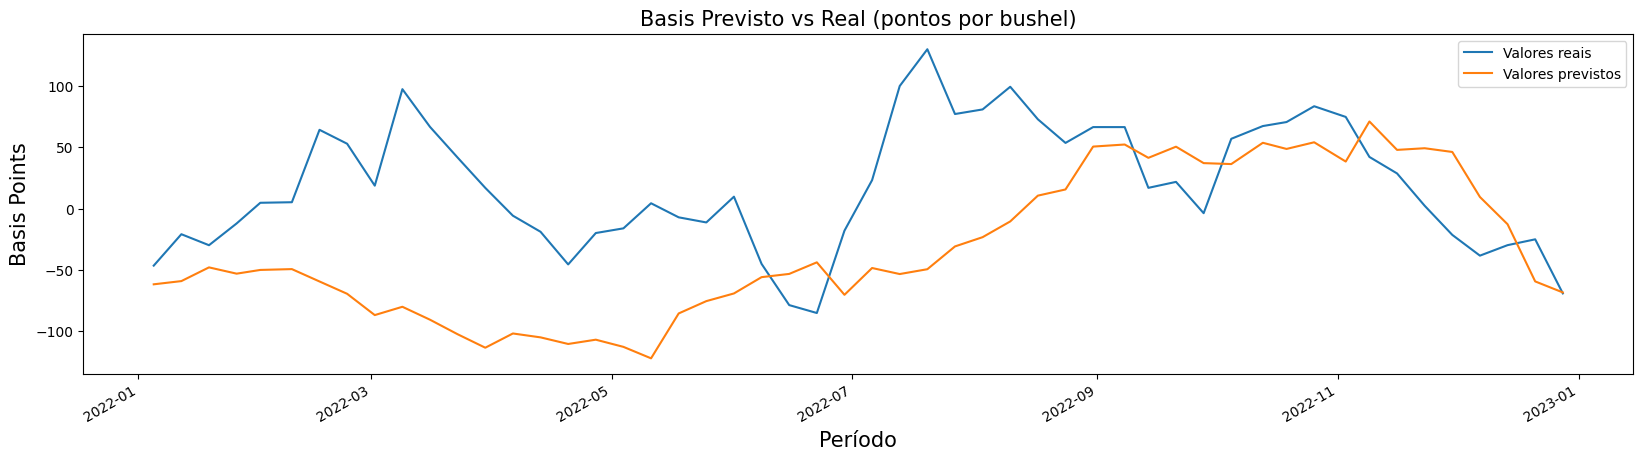

In [64]:
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2022, df_previsao_2022], axis = 1).plot(figsize = (20, 5))
plt.title('Basis Previsto vs Real (pontos por bushel)', size = 15)
plt.xlabel('Período', size = 15)
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

In [65]:
# Métodos de acurácia para 1 mês
print('1 mês:')
mae_2022_1 = mean_absolute_error(df_teste_2022.query('index >= "2022-01-01" and index < "2022-02-01"'), df_previsao_2022.query('index >= "2022-01-01" and index < "2022-02-01"'))
print(f'MAE: {mae_2022_1}')

mape_2022_1 = mean_absolute_percentage_error(df_teste_2022.query('index >= "2022-01-01" and index < "2022-02-01"'), df_previsao_2022.query('index >= "2022-01-01" and index < "2022-02-01"'))
print(f'MAPE: {mape_2022_1}.\n')

# Métodos de acurácia para 3 meses
print('3 meses:')
mae_2022_3 = mean_absolute_error(df_teste_2022.query('index >= "2022-01-01" and index < "2022-04-01"'), df_previsao_2022.query('index >= "2022-01-01" and index < "2022-04-01"'))
print(f'MAE: {mae_2022_3}')

mape_2022_3 = mean_absolute_percentage_error(df_teste_2022.query('index >= "2022-01-01" and index < "2022-04-01"'), df_previsao_2022.query('index >= "2022-01-01" and index < "2022-04-01"'))
print(f'MAPE: {mape_2022_3}.\n')

# Métodos de acurácia para 6 meses
print(f'6 meses:')
mae_2022_6 = mean_absolute_error(df_teste_2022.query('index >= "2022-01-01" and index < "2022-07-01"'), df_previsao_2022.query('index >= "2022-01-01" and index < "2022-07-01"'))
print(f'MAE: {mae_2022_6}')

mape_2022_6 = mean_absolute_percentage_error(df_teste_2022.query('index >= "2022-01-01" and index < "2022-07-01"'), df_previsao_2022.query('index >= "2022-01-01" and index < "2022-07-01"'))
print(f'MAPE: {mape_2022_6}.\n')

# Métodos de acurácia para 12 meses
print(f'12 meses:')
mae_2022_12 = mean_absolute_error(df_teste_2022, df_previsao_2022)
print(f'MAE: {mae_2022_12}')

mape_2022_12 = mean_absolute_percentage_error(df_teste_2022, df_previsao_2022)
print(f'MAPE: {mape_2022_12}.')

1 mês:
MAE: 28.13066003121837
MAPE: 1.5456612553366655.

3 meses:
MAE: 90.98952897871791
MAPE: 4.069842479361143.

6 meses:
MAE: 80.44474462575921
MAPE: 5.52126345891217.

12 meses:
MAE: 65.9090973430443
MAPE: 3.811355136560115.


### 2000-2023

##### Dados

In [66]:
# Eliminando os anos indesejados da série
df_basis_2023 = df_basis.query('index < 2024')

##### Divisão da Amostra

In [67]:
# Treino
df_treino_2023 = df_basis.query('index < 2023')

In [68]:
# Teste
df_teste_2023 = df_basis.query('index >= 2023 and index < 2024')

##### Estimação e Previsão

In [69]:
# Estimando o modelo e gerando as previsões
modelo_sarima_2023 = modelo_sarima.fit(df_treino_2023) # estimação dos coeficientes da função
previsao_2023 = modelo_sarima_2023.predict(df_teste_2023.shape[0]) # previsão

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [70]:
# Transformando a series "previsão" em um dataframe
df_previsao_2023 = pd.DataFrame(
    data = {
        "previsao": previsao_2023
    }
).set_index(df_teste_2023.index)

##### Resultado

<Figure size 2000x500 with 0 Axes>

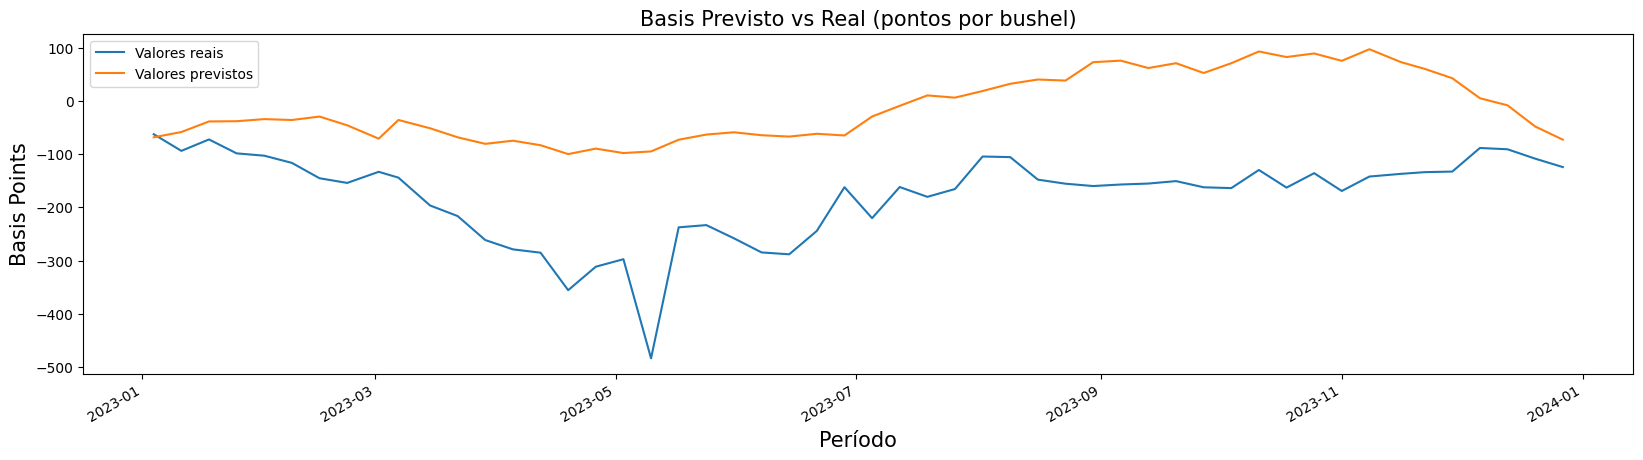

In [71]:
plt.figure(figsize = (20, 5))
pd.concat([df_teste_2023, df_previsao_2023], axis = 1).plot(figsize = (20, 5))
plt.title('Basis Previsto vs Real (pontos por bushel)', size = 15)
plt.xlabel('Período', size = 15)
plt.ylabel('Basis Points', size = 15)
plt.legend(['Valores reais', 'Valores previstos'])
plt.show()

In [72]:
# Métodos de acurácia para 1 mês
print('1 mês:')
mae_2023_1 = mean_absolute_error(df_teste_2023.query('index >= "2023-01-01" and index < "2023-02-01"'), df_previsao_2023.query('index >= "2023-01-01" and index < "2023-02-01"'))
print(f'MAE: {mae_2023_1}')

mape_2023_1 = mean_absolute_percentage_error(df_teste_2023.query('index >= "2023-01-01" and index < "2023-02-01"'), df_previsao_2023.query('index >= "2023-01-01" and index < "2023-02-01"'))
print(f'MAPE: {mape_2023_1}.\n')

# Métodos de acurácia para 3 meses
print('3 meses:')
mae_2023_3 = mean_absolute_error(df_teste_2023.query('index >= "2023-01-01" and index < "2023-04-01"'), df_previsao_2023.query('index >= "2023-01-01" and index < "2023-04-01"'))
print(f'MAE: {mae_2023_3}')

mape_2023_3 = mean_absolute_percentage_error(df_teste_2023.query('index >= "2023-01-01" and index < "2023-04-01"'), df_previsao_2023.query('index >= "2023-01-01" and index < "2023-04-01"'))
print(f'MAPE: {mape_2023_3}.\n')

# Métodos de acurácia para 6 meses
print(f'6 meses:')
mae_2023_6 = mean_absolute_error(df_teste_2023.query('index >= "2023-01-01" and index < "2023-07-01"'), df_previsao_2023.query('index >= "2023-01-01" and index < "2023-07-01"'))
print(f'MAE: {mae_2023_6}')

mape_2023_6 = mean_absolute_percentage_error(df_teste_2023.query('index >= "2023-01-01" and index < "2023-07-01"'), df_previsao_2023.query('index >= "2023-01-01" and index < "2023-07-01"'))
print(f'MAPE: {mape_2023_6}.\n')

# Métodos de acurácia para 12 meses
print(f'12 meses:')
mae_2023_12 = mean_absolute_error(df_teste_2023, df_previsao_2023)
print(f'MAE: {mae_2023_12}')

mape_2023_12 = mean_absolute_percentage_error(df_teste_2023, df_previsao_2023)
print(f'MAPE: {mape_2023_12}.')

1 mês:
MAE: 33.94170230254223
MAPE: 0.390119242248011.

3 meses:
MAE: 88.93147754939913
MAPE: 0.5981860437712833.

6 meses:
MAE: 149.58605112683014
MAPE: 0.6624036803813768.

12 meses:
MAE: 166.2677319939695
MAPE: 0.9627199809937459.


## Teste de Validação Cruzada

In [73]:
# Pré pandemia
print('   Pré Pandemia (2016-2019)      \n')

# 1 mês:
lista_mae_1_pre = [mae_2016_1, mae_2017_1, mae_2018_1, mae_2019_1]
lista_mape_1_pre = [mape_2016_1, mape_2017_1, mape_2018_1, mape_2019_1]

print(f'1 mês:')
media_mae_1_pre = sum(lista_mae_1_pre) / len(lista_mae_1_pre)
print(f'Média MAE: {media_mae_1_pre}')
media_mape_1_pre = sum(lista_mape_1_pre) / len(lista_mape_1_pre)
print(f'Média MAPE: {media_mape_1_pre}\n')

# 3 meses:
lista_mae_3_pre = [mae_2016_3, mae_2017_3, mae_2018_3, mae_2019_3]
lista_mape_3_pre = [mape_2016_3, mape_2017_3, mape_2018_3, mape_2019_3]

print(f'3 meses:')
media_mae_3_pre = sum(lista_mae_3_pre) / len(lista_mae_3_pre)
print(f'Média MAE: {media_mae_3_pre}')
media_mape_3_pre = sum(lista_mape_3_pre) / len(lista_mape_3_pre)
print(f'Média MAPE: {media_mape_3_pre}\n')

# 6 meses:
lista_mae_6_pre = [mae_2016_6, mae_2017_6, mae_2018_6, mae_2019_6]
lista_mape_6_pre = [mape_2016_6, mape_2017_6, mape_2018_6, mape_2019_6]

print(f'6 meses:')
media_mae_6_pre = sum(lista_mae_6_pre) / len(lista_mae_6_pre)
print(f'Média MAE: {media_mae_6_pre}')
media_mape_6_pre = sum(lista_mape_6_pre) / len(lista_mape_6_pre)
print(f'Média MAPE: {media_mape_6_pre}\n')

# 12 meses:
lista_mae_12_pre = [mae_2016_12, mae_2017_12, mae_2018_12, mae_2019_12]
lista_mape_12_pre = [mape_2016_12, mape_2017_12, mape_2018_12, mape_2019_12]

print(f'12 meses:')
media_mae_12_pre = sum(lista_mae_12_pre) / len(lista_mae_12_pre)
print(f'Média MAE: {media_mae_12_pre}')
media_mape_12_pre = sum(lista_mape_12_pre) / len(lista_mape_12_pre)
print(f'Média MAPE: {media_mape_12_pre}\n\n')

# Pós pandemia
print('   Pós Pandemia (2020-2023)      \n')

# 1 mês:
lista_mae_1_pos = [mae_2020_1, mae_2021_1, mae_2022_1, mae_2023_1]
lista_mape_1_pos = [mape_2020_1, mape_2021_1, mape_2022_1, mape_2023_1]

print(f'1 mês:')
media_mae_1_pos = sum(lista_mae_1_pos) / len(lista_mae_1_pos)
print(f'Média MAE: {media_mae_1_pos}')
media_mape_1_pos = sum(lista_mape_1_pos) / len(lista_mape_1_pos)
print(f'Média MAPE: {media_mape_1_pos}\n')

# 3 meses:
lista_mae_3_pos = [mae_2020_3, mae_2021_3, mae_2022_3, mae_2023_3]
lista_mape_3_pos = [mape_2020_3, mape_2021_3, mape_2022_3, mape_2023_3]

print(f'3 meses:')
media_mae_3_pos = sum(lista_mae_3_pos) / len(lista_mae_3_pos)
print(f'Média MAE: {media_mae_3_pos}')
media_mape_3_pos = sum(lista_mape_3_pos) / len(lista_mape_3_pos)
print(f'Média MAPE: {media_mape_3_pos}\n')

# 6 meses:
lista_mae_6_pos = [mae_2020_6, mae_2021_6, mae_2022_6, mae_2023_6]
lista_mape_6_pos = [mape_2020_6, mape_2021_6, mape_2022_6, mape_2023_6]

print(f'6 meses:')
media_mae_6_pos = sum(lista_mae_6_pos) / len(lista_mae_6_pos)
print(f'Média MAE: {media_mae_6_pos}')
media_mape_6_pos = sum(lista_mape_6_pos) / len(lista_mape_6_pos)
print(f'Média MAPE: {media_mape_6_pos}\n')

# 12 meses:
lista_mae_12_pos = [mae_2020_12, mae_2021_12, mae_2022_12, mae_2023_12]
lista_mape_12_pos = [mape_2020_12, mape_2021_12, mape_2022_12, mape_2023_12]

print(f'12 meses:')
media_mae_12_pos = sum(lista_mae_12_pos) / len(lista_mae_12_pos)
print(f'Média MAE: {media_mae_12_pos}')
media_mape_12_pos = sum(lista_mape_12_pos) / len(lista_mape_12_pos)
print(f'Média MAPE: {media_mape_12_pos}\n\n')


# Pré e Pós-pandemia
print('Pré e Pós-pandemia (2016-2023)      \n')

# 1 mês:
lista_mae_1_completa = [mae_2016_1, mae_2017_1, mae_2018_1, mae_2019_1, mae_2020_1, mae_2021_1, mae_2022_1, mae_2023_1]
lista_mape_1_completa = [mape_2016_1, mape_2017_1, mape_2018_1, mape_2019_1, mape_2020_1, mape_2021_1, mape_2022_1, mape_2023_1]

print(f'1 mês:')
media_mae_1_completa = sum(lista_mae_1_completa) / len(lista_mae_1_completa)
print(f'Média MAE: {media_mae_1_completa}')
media_mape_1_completa = sum(lista_mape_1_completa) / len(lista_mape_1_completa)
print(f'Média MAPE: {media_mape_1_completa}\n')

# 3 meses:
lista_mae_3_completa = [mae_2016_3, mae_2017_3, mae_2018_3, mae_2019_3, mae_2020_3, mae_2021_3, mae_2022_3, mae_2023_3]
lista_mape_3_completa = [mape_2016_3, mape_2017_3, mape_2018_3, mape_2019_3, mape_2020_3, mape_2021_3, mape_2022_3, mape_2023_3]

print(f'3 meses:')
media_mae_3_completa = sum(lista_mae_3_completa) / len(lista_mae_3_completa)
print(f'Média MAE: {media_mae_3_completa}')
media_mape_3_completa = sum(lista_mape_3_completa) / len(lista_mape_3_completa)
print(f'Média MAPE: {media_mape_3_completa}\n')

# 6 meses:
lista_mae_6_completa = [mae_2016_6, mae_2017_6, mae_2018_6, mae_2019_6, mae_2020_6, mae_2021_6, mae_2022_6, mae_2023_6]
lista_mape_6_completa = [mape_2016_6, mape_2017_6, mape_2018_6, mape_2019_6, mape_2020_6, mape_2021_6, mape_2022_6, mape_2023_6]

print(f'6 meses:')
media_mae_6_completa = sum(lista_mae_6_completa) / len(lista_mae_6_completa)
print(f'Média MAE: {media_mae_6_completa}')
media_mape_6_completa = sum(lista_mape_6_completa) / len(lista_mape_6_completa)
print(f'Média MAPE: {media_mape_6_completa}\n')

# 12 meses:
lista_mae_12_completa = [mae_2016_12, mae_2017_12, mae_2018_12, mae_2019_12, mae_2020_12, mae_2021_12, mae_2022_12, mae_2023_12]
lista_mape_12_completa = [mape_2016_12, mape_2017_12, mape_2018_12, mape_2019_12, mape_2020_12, mape_2021_12, mape_2022_12, mape_2023_12]

print(f'12 meses:')
media_mae_12_completa = sum(lista_mae_12_completa) / len(lista_mae_12_completa)
print(f'Média MAE: {media_mae_12_completa}')
media_mape_12_completa = sum(lista_mape_12_completa) / len(lista_mape_12_completa)
print(f'Média MAPE: {media_mape_12_completa}')

   Pré Pandemia (2016-2019)      

1 mês:
Média MAE: 26.243500091193052
Média MAPE: 0.3574644775194165

3 meses:
Média MAE: 40.80744304980467
Média MAPE: 0.5617525275034165

6 meses:
Média MAE: 44.790482715694104
Média MAPE: 1.0081155206274692

12 meses:
Média MAE: 59.66886039988701
Média MAPE: 28.359196522617605


   Pós Pandemia (2020-2023)      

1 mês:
Média MAE: 29.304909124404347
Média MAPE: 0.8295554308421642

3 meses:
Média MAE: 59.9426973107154
Média MAPE: 1.3830297182914997

6 meses:
Média MAE: 80.40250757765978
Média MAPE: 2.04153751653461

12 meses:
Média MAE: 87.0006899099468
Média MAPE: 3.2827608503685015


Pré e Pós-pandemia (2016-2023)      

1 mês:
Média MAE: 27.7742046077987
Média MAPE: 0.5935099541807904

3 meses:
Média MAE: 50.37507018026004
Média MAPE: 0.9723911228974582

6 meses:
Média MAE: 62.59649514667694
Média MAPE: 1.52482651858104

12 meses:
Média MAE: 73.3347751549169
Média MAPE: 15.820978686493053


In [74]:
# Criando listas com os resultados da reamostragem
pre_pandemia = [media_mae_1_pre, media_mae_3_pre, media_mae_6_pre, media_mae_12_pre]
pos_pandemia = [media_mae_1_pos, media_mae_3_pos, media_mae_6_pos, media_mae_12_pos]
completa = [media_mae_1_completa, media_mae_3_completa, media_mae_6_completa, media_mae_12_completa]

In [75]:
# Criando uma tabela com os dados das listas
final = pd.DataFrame(
    data = {
        'Pré Pandemia': pre_pandemia,
        'Pós Pandemia': pos_pandemia,
        # 'Completa': completa
    },
    index = ['1 mês', '3 meses', '6 meses', '12 meses']
)
final

,Pré Pandemia,Pós Pandemia
1 mês,26.243500,29.304909
3 meses,40.807443,59.942697
6 meses,44.790483,80.402508
12 meses,59.668860,87.000690


<Figure size 1500x500 with 0 Axes>

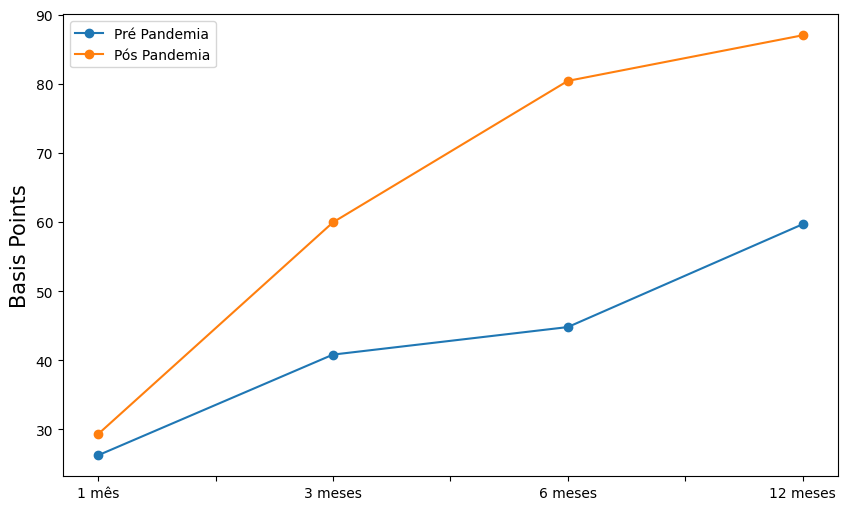

In [76]:
# Gráfico de comparação pré vs pós pandemia
plt.figure(figsize = (15, 5))
pd.concat([final], axis = 1).plot(marker = 'o')
plt.ylabel('Basis Points', size = 15)
plt.legend(['Pré Pandemia', 'Pós Pandemia', 'Pré e Pós'])
plt.show()